MNIST dataset using KNN 

In [ ]:
import tkinter as tk
import cv2
import numpy as np
from PIL import Image, ImageDraw
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib.pyplot as plt

Step 1: Data Preparation

In [2]:
# Load the MNIST dataset from TensorFlow datasets
mnist = tf.keras.datasets.mnist

# Load training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the dataset
X_train = X_train / 255.0
X_test = X_test / 255.0

Step 2: Process the data

In [3]:
# Flatten the images from 28x28 to 784 features (28*28)
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)


Step 3: Train the KNN Model

In [4]:
# Create the KNN model with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=1)

# Train the model using the training data
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=1)

Step 4: Process captured frames

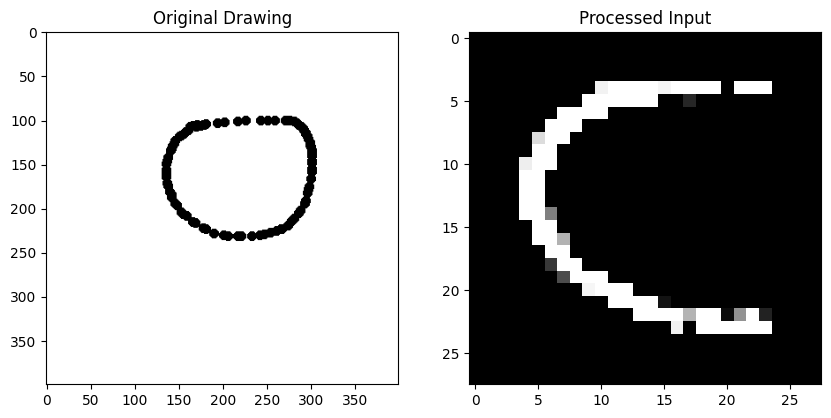

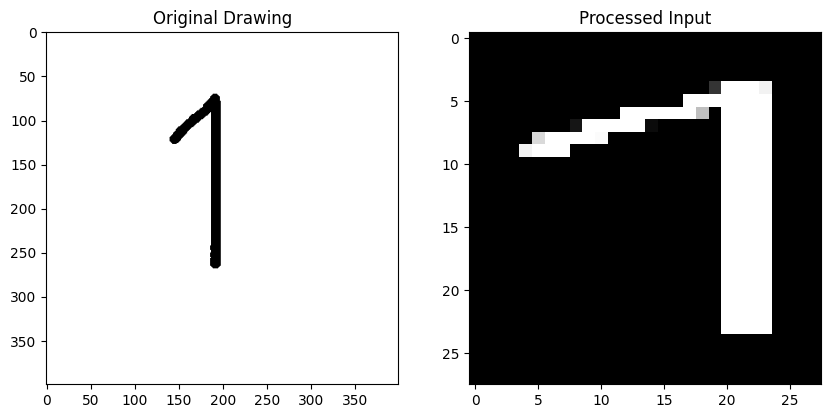

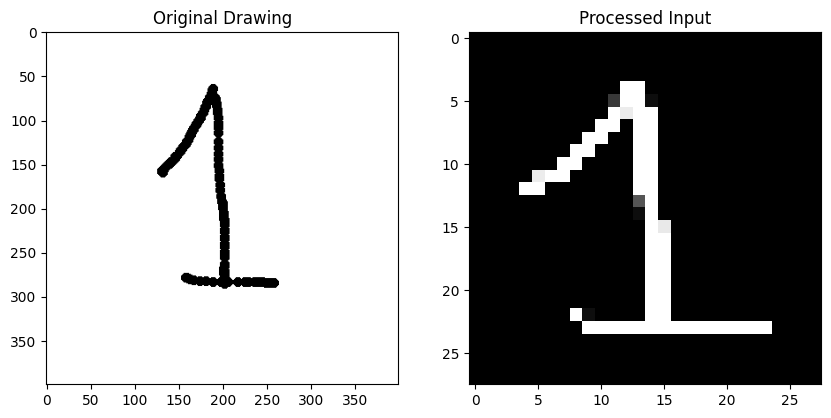

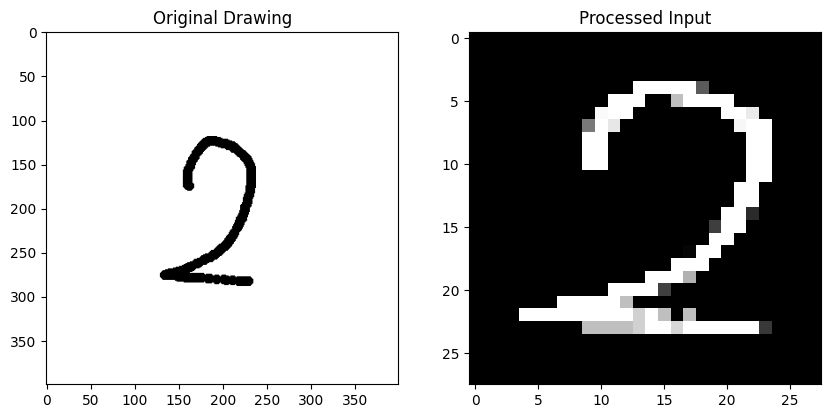

In [5]:
# Create a Pillow image for the canvas
canvas_width = 400
canvas_height = 400
image = Image.new('L', (canvas_width, canvas_height), color=255)  # White background
draw = ImageDraw.Draw(image)

# Function to preprocess the image for prediction
def preprocess_image(pillow_image):
    # Convert Pillow image to a NumPy array
    image_array = np.array(pillow_image)

    # Threshold the image to create a binary (black/white) version
    _, binary_image = cv2.threshold(image_array, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours to detect the digit
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))

        # Crop the digit using the bounding box
        digit = binary_image[y:y+h, x:x+w]

        # Resize the cropped digit to 20x20
        resized_digit = cv2.resize(digit, (20, 20))

        # Pad the digit to fit 28x28
        padded_digit = cv2.copyMakeBorder(resized_digit, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
    else:
        # Fallback if no contours are detected
        padded_digit = np.zeros((28, 28), dtype=np.uint8)

    # Normalize the pixel values and flatten
    normalized_digit = padded_digit / 255.0
    flattened_digit = normalized_digit.flatten().reshape(1, -1)

    return flattened_digit


# Function to predict the drawn digit
def predict_digit():
    # Convert the Pillow image to NumPy array and preprocess
    processed_image = preprocess_image(image)

    # Visualize intermediate results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Drawing")
    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.reshape(28, 28), cmap="gray")
    plt.title("Processed Input")
    plt.show()

    # Predict using the KNN model
    prediction = knn.predict(processed_image)
    predicted_label = prediction[0]

    # Display the prediction result
    result_label.config(text=f"Prediction: {predicted_label}")


# Function to draw on the canvas and Pillow image
def paint(event):
    x1, y1 = (event.x - 5), (event.y - 5)
    x2, y2 = (event.x + 5), (event.y + 5)

    # Draw on the Tkinter canvas
    canvas.create_oval(x1, y1, x2, y2, fill="black", width=5)

    # Draw on the Pillow image with anti-aliasing
    draw.ellipse([x1, y1, x2, y2], fill=0)  # Black color for the digit

# Function to clear the canvas and Pillow image
def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, canvas_width, canvas_height], fill=255)  # Reset Pillow image to white
    result_label.config(text="Prediction: None")

# Create the Tkinter GUI
root = tk.Tk()
root.title("Handwritten Digit Recognition")

canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg="white")
canvas.pack()

# Bind the paint function to the left mouse button
canvas.bind("<B1-Motion>", paint)

# Add buttons for prediction and clearing the canvas
predict_button = tk.Button(root, text="Predict", command=predict_digit)
predict_button.pack()

clear_button = tk.Button(root, text="Clear", command=clear_canvas)
clear_button.pack()

# Label to display the prediction result
result_label = tk.Label(root, text="Prediction: None", font=("Helvetica", 16))
result_label.pack()

# Run the Tkinter main loop
root.mainloop()

Step 4: Test the model

In [ ]:
# Evaluate accuracy on the test set
accuracy = knn.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Step 5: Prediction Analysis

In [ ]:
# Pick an image from the test set
sample_idx = 0
sample_image = X_test[sample_idx].reshape(28, 28)
sample_label = y_test[sample_idx]

# Predict the label
predicted_label = knn.predict([X_test[sample_idx]])[0]

# Display the image and the prediction
plt.imshow(sample_image, cmap='gray')
plt.title(f'Predicted: {predicted_label}, Actual: {sample_label}')
plt.axis('off')
plt.show()
